# Telco Churn — Simple End-to-End ML Notebook

**Goal:** prepare clean data, try a few classic models, pick the best, and save artifacts
for an API (feature list, scaler, model).

**Notes**
- Business rule: if tenure == 0 AND Total_Charges is missing => set Total_Charges = 0 for those rows.


In [ ]:
# Imports & paths
import pandas as pd
import numpy as np
import json, joblib
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, f1_score, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Paths
DATA_PATH = Path(r"C:\Users\mfarouk\Desktop\telco_churn_project\data\WA_Fn-UseC_-Telco-Customer-Churn.csv")
ARTIFACT_DIR = Path(r"C:\Users\mfarouk\Desktop\telco_churn_project\app\model")
FEATURES_PATH = ARTIFACT_DIR / "features.json"
SCALER_PATH = ARTIFACT_DIR / "scaler.pkl"
MODEL_PATH = ARTIFACT_DIR / "churn_model.pkl"


## 1) Load the data

In [2]:
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
df.head(3)


Raw shape: (7043, 21)


,customerID,gender,Senior_Citizen,Is_Married,Dependents,tenure,Phone_Service,Dual,Internet_Service,Online_Security,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## 2) Normalize column names and basic cleaning

We will:
- Strip whitespace from column names.
- Fix known casing/underscore differences:
  - `gender` -> `Gender`
  - `MonthlyCharges` -> `Monthly_Charges`
  - `TotalCharges`   -> `Total_Charges`
  - `SeniorCitizen`  -> `Senior_Citizen`
- Ensure target `Churn` exists.

In [3]:
# strip spaces
df.columns = df.columns.str.strip()

# rename common variants to our canonical schema
rename_map = {
    "gender": "Gender",
    "SeniorCitizen": "Senior_Citizen",
    "MonthlyCharges": "Monthly_Charges",
    "TotalCharges": "Total_Charges",
    "CustomerID": "customerID",
    "customerID": "customerID",
}
df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

assert "Churn" in df.columns, "Expected 'Churn' column."

print("Columns:", list(df.columns))


Columns: ['customerID', 'Gender', 'Senior_Citizen', 'Is_Married', 'Dependents', 'tenure', 'Phone_Service', 'Dual', 'Internet_Service', 'Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges', 'Total_Charges', 'Churn']


## 3) Handle dtypes and **business rule** for Total_Charges

- Make `Total_Charges` numeric (blanks -> NaN).
- **Business rule**: if `tenure == 0` and `Total_Charges` is NaN, set it to 0.
- For anything else still missing in essential numeric fields, we'll drop.

In [4]:
# coerce numerics
df["Total_Charges"] = pd.to_numeric(df["Total_Charges"], errors="coerce")
df["Monthly_Charges"] = pd.to_numeric(df["Monthly_Charges"], errors="coerce")
df["tenure"] = pd.to_numeric(df["tenure"], errors="coerce")
df["Senior_Citizen"] = pd.to_numeric(df["Senior_Citizen"], errors="coerce")

# apply business rule
mask_rule = (df["tenure"] == 0) & (df["Total_Charges"].isna())
affected = mask_rule.sum()
df.loc[mask_rule, "Total_Charges"] = 0.0
print(f"Business rule applied to rows: {affected}")

# drop remaining NA in essential fields (if any)
essential = ["tenure", "Monthly_Charges", "Total_Charges", "Senior_Citizen", "Churn"]
before = len(df)
df = df.dropna(subset=essential)
after = len(df)
print("Dropped rows after NA handling:", before - after)


Business rule applied to rows: 11
Dropped rows after NA handling: 0


## 4) Quick EDA

- Check shapes and missing values (should be none now in essentials).
- Look at target balance.
- Basic numeric distributions.

In [5]:
print("Shape:", df.shape)
print("\nMissing values per column (non-zero only):")
mv = df.isna().sum()
print(mv[mv > 0].sort_values(ascending=False))

print("\nTarget distribution:")
vc = df["Churn"].astype(str).str.strip().str.lower().value_counts()
print(vc, "\nChurn rate:", round(vc.get("yes", 0) / vc.sum(), 3))

# simple numeric description
num_cols_quick = ["tenure", "Monthly_Charges", "Total_Charges", "Senior_Citizen"]
df[num_cols_quick].describe()


Shape: (7043, 21)

Missing values per column (non-zero only):
Series([], dtype: int64)

Target distribution:
Churn
no     5174
yes    1869
Name: count, dtype: int64 
Churn rate: 0.265


,tenure,Monthly_Charges,Total_Charges,Senior_Citizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304,0.162147
std,24.559481,30.090047,2266.794470,0.368612
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.500000,398.550000,0.000000
50%,29.000000,70.350000,1394.550000,0.000000
75%,55.000000,89.850000,3786.600000,0.000000
max,72.000000,118.750000,8684.800000,1.000000


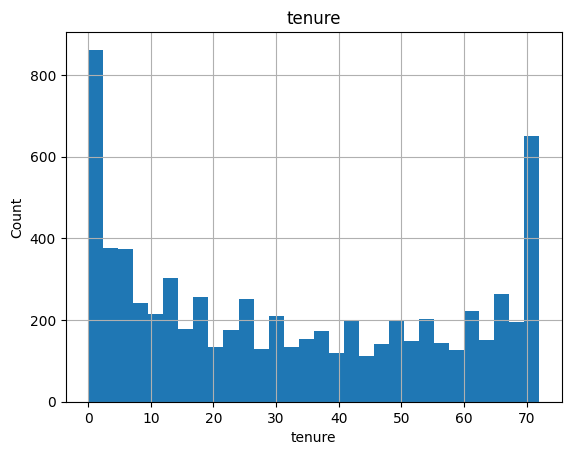

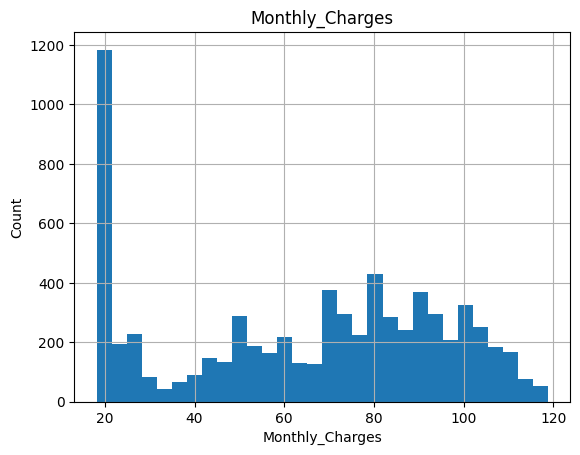

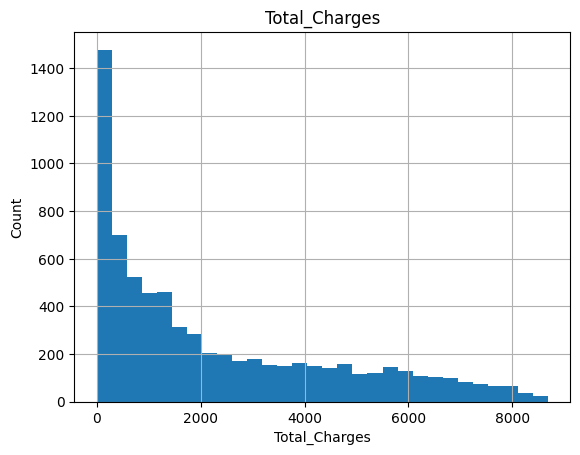

In [6]:
# simple histograms
for c in ["tenure", "Monthly_Charges", "Total_Charges"]:
    df[c].dropna().hist(bins=30)
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.show()


## 5) Prepare features and target

- Drop ID (customerID).
- Normalize target to 1/0.
- Choose numeric and categorical columns (based on your schema).
- Do **not** engineer extra features here; keep it minimal.

In [7]:
# drop ID-like column if present
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# target as 1/0
y = (df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

# choose columns
numeric_cols = ["tenure", "Monthly_Charges", "Total_Charges", "Senior_Citizen"]
categorical_cols = [
    "Gender", "Is_Married", "Dependents", "Phone_Service", "Dual",
    "Internet_Service", "Online_Security", "Online_Backup",
    "Device_Protection", "Tech_Support", "Streaming_TV", "Streaming_Movies",
    "Contract", "Paperless_Billing", "Payment_Method"
]

# ensure they exist
missing_in_schema = [c for c in numeric_cols + categorical_cols if c not in df.columns]
if missing_in_schema:
    raise ValueError(f"Missing columns in data: {missing_in_schema}")

X = df[numeric_cols + categorical_cols].copy()
X.head(3)


,tenure,Monthly_Charges,Total_Charges,Senior_Citizen,Gender,Is_Married,Dependents,Phone_Service,Dual,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method
0,1,29.85,29.85,0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,34,56.95,1889.50,0,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,2,53.85,108.15,0,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check


## 6) Train / validation split

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_valid.shape


((5634, 19), (1409, 19))

## 7) One-hot encode categoricals and **save feature list**

We use `pd.get_dummies(drop_first=True)`.
We save the **exact** column order to `features.json` — as I will use this later in the API.

In [9]:
# one-hot on train
X_train_cat = pd.get_dummies(X_train[categorical_cols], drop_first=True)
X_train_num = X_train[numeric_cols].copy()
X_train_enc = pd.concat([X_train_num, X_train_cat], axis=1)

# one-hot on valid and align to train columns
X_valid_cat = pd.get_dummies(X_valid[categorical_cols], drop_first=True)
X_valid_num = X_valid[numeric_cols].copy()
X_valid_enc = pd.concat([X_valid_num, X_valid_cat], axis=1).reindex(columns=X_train_enc.columns, fill_value=0)

# save features list
FEATURES = list(X_train_enc.columns)
with open(FEATURES_PATH, "w") as f:
    json.dump(FEATURES, f)
print("Saved features to:", FEATURES_PATH)


Saved features to: C:\Users\mfarouk\Desktop\telco_churn_project\app\model\features.json


## 8) Scale features and **save scaler**

scale **all** encoded features for simplicity.

In [10]:
scaler = StandardScaler()
scaler.fit(X_train_enc)

X_train_scaled = scaler.transform(X_train_enc)
X_valid_scaled = scaler.transform(X_valid_enc)

joblib.dump(scaler, SCALER_PATH)
print("Saved scaler to:", SCALER_PATH)


Saved scaler to: C:\Users\mfarouk\Desktop\telco_churn_project\app\model\scaler.pkl


## 9) Train multiple simple models

We will train 5 models:
- Logistic Regression
- Random Forest
- Gradient Boosting
- SVC (with probability=True)
- KNN

We will compare them by ROC-AUC (primary), then PR-AUC as tie-breaker.

In [11]:
models = {
    "LogReg": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42),
    "GradBoost": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(probability=True, kernel="rbf", C=1.0, gamma="scale", random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=15),
}

results = []
fitted = {}

for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    fitted[name] = clf

    proba = clf.predict_proba(X_valid_scaled)[:, 1]
    pred = (proba >= 0.5).astype(int)

    roc = roc_auc_score(y_valid, proba)
    prauc = average_precision_score(y_valid, proba)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)

    results.append({
        "model": name,
        "ROC_AUC": roc,
        "PR_AUC": prauc,
        "Accuracy": acc,
        "F1": f1
    })

    print(f"\n=== {name} ===")
    print("ROC-AUC:", round(roc,4), "| PR-AUC:", round(prauc,4),
          "| Acc:", round(acc,4), "| F1:", round(f1,4))

results_df = pd.DataFrame(results).sort_values(by=["ROC_AUC","PR_AUC"], ascending=False).reset_index(drop=True)
results_df



=== LogReg ===
ROC-AUC: 0.8418 | PR-AUC: 0.6324 | Acc: 0.807 | F1: 0.6092

=== RandomForest ===
ROC-AUC: 0.8283 | PR-AUC: 0.6254 | Acc: 0.7885 | F1: 0.5526

=== GradBoost ===
ROC-AUC: 0.8415 | PR-AUC: 0.6518 | Acc: 0.7977 | F1: 0.5701

=== SVC ===
ROC-AUC: 0.7961 | PR-AUC: 0.6142 | Acc: 0.7935 | F1: 0.5344

=== KNN ===
ROC-AUC: 0.8082 | PR-AUC: 0.5759 | Acc: 0.77 | F1: 0.5537


,model,ROC_AUC,PR_AUC,Accuracy,F1
0,LogReg,0.841778,0.632372,0.806955,0.609195
1,GradBoost,0.841517,0.651815,0.797729,0.570136
2,RandomForest,0.828285,0.625437,0.788502,0.552553
3,KNN,0.808174,0.575940,0.770050,0.553719
4,SVC,0.796125,0.614186,0.793471,0.534400


## 10) Pick best model, save it, and final validation report

In [21]:
best_name = results_df.loc[0, "model"]
best_model = fitted[best_name]
print("Best model:", best_name)
print(results_df.head())

# Final report
val_proba = best_model.predict_proba(X_valid_scaled)[:, 1]
val_pred = (val_proba >= 0.5).astype(int)

print("\nFinal Validation Metrics")
print("ROC-AUC:", round(roc_auc_score(y_valid, val_proba), 4))
print("PR-AUC :", round(average_precision_score(y_valid, val_proba), 4))
print("\nClassification Report:")
print(classification_report(y_valid, val_pred, digits=4))

# save best model
joblib.dump(best_model, MODEL_PATH)
print("\nSaved model to:", MODEL_PATH)


Best model: LogReg
          model   ROC_AUC    PR_AUC  Accuracy        F1
0        LogReg  0.841778  0.632372  0.806955  0.609195
1     GradBoost  0.841517  0.651815  0.797729  0.570136
2  RandomForest  0.828285  0.625437  0.788502  0.552553
3           KNN  0.808174  0.575940  0.770050  0.553719
4           SVC  0.796125  0.614186  0.793471  0.534400

Final Validation Metrics
ROC-AUC: 0.8418
PR-AUC : 0.6324

Classification Report:
              precision    recall  f1-score   support

           0     0.8510    0.8937    0.8718      1035
           1     0.6584    0.5668    0.6092       374

    accuracy                         0.8070      1409
   macro avg     0.7547    0.7303    0.7405      1409
weighted avg     0.7998    0.8070    0.8021      1409


Saved model to: C:\Users\mfarouk\Desktop\telco_churn_project\app\model\churn_model.pkl
